## LSBG - Artifact classification using Vision Transformers

In this notebook we implement **from scrtch** a **Vision Transformer** (ViT) for the problem of LSBG vs Artifact classification.

We apply Transformer architecture with self-attention without convolutional layers. We closely follow the Keras implementation that can be found at https://keras.io/examples/vision/image_classification_with_vision_transformer/

Install Tensorflow addons

In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 32.6 MB/s 


**Import basic packages**

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [3]:
# ==============================================
# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

**Download and prepare the data**

In [4]:
num_classes = 2
input_shape = (64, 64, 3)

In [5]:
# Remove 
!rm -rf UPenn_DS_Hangout
!git clone https://github.com/dtanoglidis/UPenn_DS_Hangout

Cloning into 'UPenn_DS_Hangout'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 21 (delta 3), reused 7 (delta 1), pack-reused 12
Unpacking objects: 100% (21/21), done.
Checking out files: 100% (7/7), done.


In [6]:
%cd UPenn_DS_Hangout

/content/UPenn_DS_Hangout


In [7]:
# Data
# Note: I have split the data into different files, only because GitHub does not 
# allow to upload very large files at ones
X_1 = np.load("X_data_1.npy");X_2 = np.load("X_data_2.npy");X_3 = np.load("X_data_3.npy")
X_4 = np.load("X_data_4.npy");X_5 = np.load("X_data_5.npy") 

X_data = np.concatenate((X_1,X_2,X_3,X_4,X_5))

# Labels
y_lab = np.load("y_labels.npy")

**Split into training/validation/test sets**

In [8]:
# Data
x_train = X_data[:4000]
x_val = X_data[4000:4500]
x_test = X_data[4500:]
# Labels
y_train = y_lab[:4000]
y_val = y_lab[4000:4500]
y_test = y_lab[4500:]

### Configure Hyperparameters

In [9]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

### Use data augmentation

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02)
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

### Implement multilayer perceptron (MLP)

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### Implement patch creation as a layer

In [12]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Let's display patches for a randomly selected image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


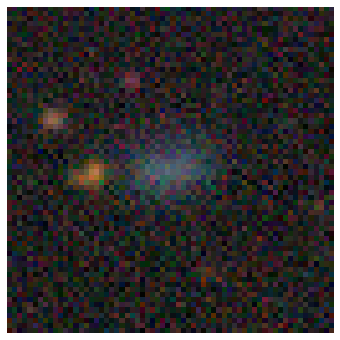

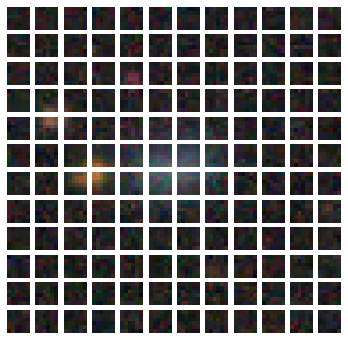

In [13]:
plt.figure(figsize=(6, 6))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(6, 6))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

### Implement the patch encoding layer 

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.



In [14]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### Build the ViT model

The ViT model consists of multiple Transformer blocks, which use the `layers.MultiHeadAttention` layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a `[batch_size, num_patches, projection_dim]` tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.

In [39]:

tf.keras.backend.clear_session()

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1, activation='sigmoid')(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

### Compile and train the model

In [40]:
model = create_vit_classifier()

In [41]:
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1)

In [42]:
 model.compile(
        optimizer=optimizer,
        loss= 'binary_crossentropy',
        metrics=['accuracy'])

In [43]:
n_epochs = 50
model.fit(x=x_train, y=y_train,
          epochs=n_epochs, batch_size=64,
          shuffle=True,
          validation_data=(x_val,y_val))

Epoch 1/50
63/63 [==============================] - 18s 145ms/step - loss: 0.7576 - accuracy: 0.7358 - val_loss: 0.7332 - val_accuracy: 0.7840
Epoch 2/50
63/63 [==============================] - 8s 126ms/step - loss: 0.5292 - accuracy: 0.8015 - val_loss: 0.3928 - val_accuracy: 0.8420
Epoch 3/50
63/63 [==============================] - 8s 127ms/step - loss: 0.4594 - accuracy: 0.8210 - val_loss: 0.4120 - val_accuracy: 0.8440
Epoch 4/50
63/63 [==============================] - 8s 128ms/step - loss: 0.4230 - accuracy: 0.8360 - val_loss: 0.4697 - val_accuracy: 0.8220
Epoch 5/50
63/63 [==============================] - 8s 127ms/step - loss: 0.3909 - accuracy: 0.8460 - val_loss: 0.4625 - val_accuracy: 0.8260
Epoch 6/50
63/63 [==============================] - 8s 127ms/step - loss: 0.3686 - accuracy: 0.8558 - val_loss: 0.3370 - val_accuracy: 0.8640
Epoch 7/50
63/63 [==============================] - 8s 127ms/step - loss: 0.3496 - accuracy: 0.8600 - val_loss: 0.5414 - val_accuracy: 0.7840
Epoch

### Make predictions and evaluate

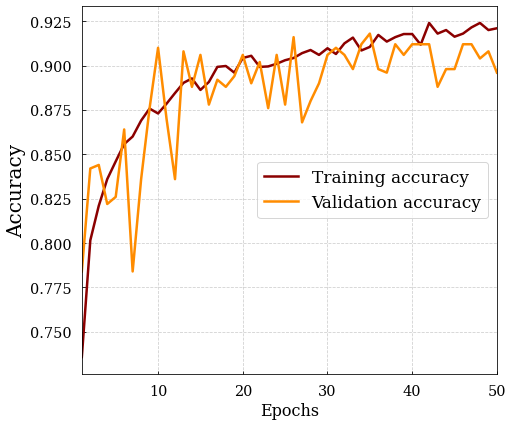

In [44]:
Epochs = np.arange(1,n_epochs+1,1)
history_dict = model.history.history

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_err = 1.0 - np.asarray(train_acc)
val_err = 1.0 - np.asarray(val_acc)

# =====================================================================
# =====================================================================
plt.figure(figsize=(7.2, 6.0))

# Plot Accuracy
plt.plot(Epochs, train_acc, c = 'darkred',linewidth=2.5,label='Training accuracy')
plt.plot(Epochs, val_acc , c = 'darkorange',linewidth=2.5,label='Validation accuracy')
# Plot Loss
#plt.plot(Epochs, train_loss, c = 'mediumblue',linewidth=2.5,label='Training loss')
#plt.plot(Epochs, val_loss , c = 'dodgerblue',linewidth=2.5,label='Validation loss')

# =====================================================================
plt.grid(ls='--',alpha=0.6)
plt.xlabel('Epochs', fontsize=16);plt.ylabel('Accuracy',fontsize=20)
plt.xlim(1,n_epochs)
#plt.ylim(0.2,1)
plt.legend(frameon=True, loc='center right', fontsize=17)
plt.tick_params(axis='both', labelsize=14.5)


#plt.xlim(10,);plt.ylim(0,2)
plt.tight_layout()
plt.show()


In [45]:
# Metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [46]:
# Predict on test data 
scores = model.predict(x_test)

# What if we change that?
y_pred_ViT =  (scores > 0.5).astype("int32")[:,0]

16/16 [==============================] - 1s 25ms/step


In [48]:
print(scores[0:10])

[[0.0636828 ]
 [0.9606801 ]
 [0.95953435]
 [0.917676  ]
 [0.08573611]
 [0.9661397 ]
 [0.84384304]
 [0.89326096]
 [0.00959872]
 [0.9253352 ]]


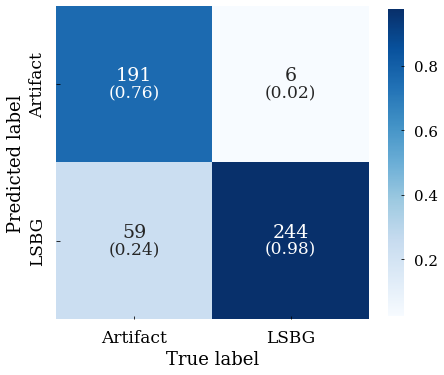

In [49]:
# Get the confusion matrix for the Deep Learning
con_mat_DL = confusion_matrix(y_test, y_pred_ViT)

# Get annotations and normalized confusion matrix
a = con_mat_DL[0]/np.sum(con_mat_DL[0])
b = con_mat_DL[1]/np.sum(con_mat_DL[1])


con_mat_normalized = np.zeros([2,2])
con_mat_normalized[0] = a
con_mat_normalized[1] = b

# Annotations
an_1 = "("+"{:.2f}".format(a[0])+")"
an_2 = "("+"{:.2f}".format(a[1])+")"
an_3 = "("+"{:.2f}".format(b[0])+")"
an_4 = "("+"{:.2f}".format(b[1])+")"

annots = np.zeros([2,2],dtype='U6')

annots[0,0] = an_1;annots[0,1] = an_2
annots[1,0] = an_3;annots[1,1] = an_4

class_names = ['Artifact','LSBG']
# ==============================================
# ==============================================


plt.figure(figsize = (7,6.0))
g =sns.heatmap(con_mat_DL.T, square = True, annot=True,annot_kws={'va':'bottom',"size": 19},fmt='.0f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)
sns.heatmap(con_mat_normalized.T, square=True, annot=annots.T, annot_kws={'va':'top',"size": 17},cmap='Blues',fmt='', cbar=True,
            cbar_kws={'shrink':0.94})
g.set_xticklabels(class_names, fontsize = 17)
g.set_yticklabels(class_names, fontsize = 17)

# Ticks for colorbar
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
# =========================================
# =========================================
plt.xlabel('True label',fontsize=18)
plt.ylabel('Predicted label',fontsize=18)
plt.show()

In [51]:
print(accuracy_score(y_test,y_pred_ViT))
print(precision_score(y_test,y_pred_ViT))
print(recall_score(y_test,y_pred_ViT))

0.87
0.8052805280528053
0.976
